
#  XGBoost Model for Predicting Staff Termination

**Author:** Omkar Masurekar

**Description:** This notebook demonstrates the process of feature engineering, model training, and prediction using the XGBoost algorithm to identify the likelihood of staff termination. The workflow includes data preprocessing, handling categorical variables, and evaluating model performance to provide actionable insights into employee attrition risk.



In [392]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [393]:
df= pd.read_csv(r"./cleaned_test_csv.csv")

In [394]:
df

,Unnamed: 0,FirstName,LastName,StartDate,ExitDate,PositionTitle,Supervisor,ADEmail,Faculty,EmployeeStatus,EmployeeType,TerminationType,DOB,JobFunction,GenderCode,Current Employee Rating,Employee ID,Survey Date,Engagement Score,Satisfaction Score,Work-Life Balance Score,StaffType,EmploymentDuration_months,TerminationYear,TerminationMonth,TerminationYearMonth,TenureGroup,EmploymentStatus,StatusValidated,TerminationCategory,VoluntaryTermination,InvoluntaryTermination,ActiveStaff,RetirementCategory,TerminatedStaff,RetainedOver2Years,Total_Survey_Score,PerformanceGroup,EngagementGroup,SatisfactionGroup,Work-Life_BalanceGroup,Total_Survey_Group
0,0,Aaden,Mercer,2023-07-26,NaN,Senior Research Fellow,Victoria Jacobs,aaden.mercer@bilearner.com,Faculty of Medicine,Active,Part-Time,Unk,25/9/1983,Senior Research Fellow,Female,3,1808,2023-04-25,5,2,4,Academic,22.033333,Active,NaN,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,0,3.666667,Medium,High,Low,High,Medium
1,1,Aaliyah,Watts,2020-05-09,NaN,Senior Lecturer,Jared Whitehead,aaliyah.watts@bilearner.com,Faculty of Medicine,Active,Contract,Unk,11/4/1962,Senior Lecturer,Male,3,3783,2023-03-07,3,4,3,Academic,61.133333,Active,NaN,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Medium,Medium,High,Medium,Medium
2,2,Aarav,Espinoza,2019-11-11,NaN,Officer,David Ali,aarav.espinoza@bilearner.com,Faculty of Arts,Active,Part-Time,Unk,15/12/1999,Administration-Officer,Male,2,2956,2023-02-06,5,4,1,Professional,67.133333,Active,NaN,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Low,High,High,Low,Medium
3,3,Aaron,Tapia,2023-01-20,NaN,Officer,Michael Reed,aaron.tapia@bilearner.com,Faculty of Arts,Active,Contract,Unk,18/1/2001,Student Services-Officer,Male,3,1538,2022-11-11,2,4,5,Professional,28.266667,Active,NaN,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,Low,High,High,Medium
4,4,Aaron,Weber,2020-04-06,2023-07-24,Lecturer,Melanie Garcia,aaron.weber@bilearner.com,Faculty of Engineering,Active,Full-Time,Involuntary,27/10/1991,Lecturer,Male,2,3541,2022-11-28,1,3,3,Academic,40.133333,2023.0,7.0,2023-07,3-5yrs,Terminated,Terminated,Involuntary Departure,0,1,0,0,1,0,2.333333,Low,Low,Medium,Medium,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,Zoey,Page,2019-05-06,2022-04-09,Professor,William Newman,zoey.page@bilearner.com,Faculty of Engineering,Active,Contract,Resignation,7/1/1987,Professor,Female,3,1817,2023-02-28,3,1,5,Academic,35.633333,2022.0,4.0,2022-04,1-3yrs,Terminated,Terminated,Voluntary Departure,1,0,0,0,1,0,3.000000,Medium,Medium,Low,High,Medium
2996,2996,Zoey,Spence,2020-05-06,NaN,Senior Lecturer,Ian Price,zoey.spence@bilearner.com,Faculty of Medicine,Active,Full-Time,Unk,8/12/1955,Senior Lecturer,Male,3,1492,2023-04-17,4,5,2,Academic,61.233333,Active,NaN,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,High,High,Low,Medium
2997,2997,Zoie,Logan,2019-04-19,NaN,Lecturer,Heidi Terry,zoie.logan@bilearner.com,Faculty of Engineering,Active,Part-Time,Unk,17/9/1990,Lecturer,Male,1,3388,2022-10-09,3,1,3,Academic,74.000000,Active,NaN,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,2.333333,Low,Medium,Low,Medium,Low
2998,2998,Zoie,Mercado,2020-12-01,NaN,Lecturer,David Young,zoie.mercado@bilearner.com,Faculty of Medicine,Active,Contract,Unk,19/8/1944,Lecturer,Female,3,1489,2022-10-13,3,5,2,Academic,54.266667,Active,NaN,NaN,3-5yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Medium,Medium,High,Low,Medium


In [395]:
df.columns

Index(['Unnamed: 0', 'FirstName', 'LastName', 'StartDate', 'ExitDate',
       'PositionTitle', 'Supervisor', 'ADEmail', 'Faculty', 'EmployeeStatus',
       'EmployeeType', 'TerminationType', 'DOB', 'JobFunction', 'GenderCode',
       'Current Employee Rating', 'Employee ID', 'Survey Date',
       'Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score',
       'StaffType', 'EmploymentDuration_months', 'TerminationYear',
       'TerminationMonth', 'TerminationYearMonth', 'TenureGroup',
       'EmploymentStatus', 'StatusValidated', 'TerminationCategory',
       'VoluntaryTermination', 'InvoluntaryTermination', 'ActiveStaff',
       'RetirementCategory', 'TerminatedStaff', 'RetainedOver2Years',
       'Total_Survey_Score', 'PerformanceGroup', 'EngagementGroup',
       'SatisfactionGroup', 'Work-Life_BalanceGroup', 'Total_Survey_Group'],
      dtype='object')

In [396]:
df['DOB'] = pd.to_datetime(df['DOB'], dayfirst=True, errors='coerce')
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['Age'] = (pd.Timestamp.today() - df['DOB']).dt.days // 365
df['TerminationMonth'] = df['TerminationMonth'].fillna('Active')

In [397]:
df['TenureGroup'].unique()

array(['1-3yrs', '5-10yrs', '3-5yrs', '<1yr', '0'], dtype=object)

Since JobFunction and PositionTitle have a large number of categorical values, we applied label encoding to convert each category into an integer value. This approach helps simplify these features for the model and improves training efficiency.

In [398]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


for col in ['JobFunction', 'PositionTitle']:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown')  # Handle missing values
    df[col + '_LE'] = le.fit_transform(df[col])

In [399]:
tenure_order = ['0', '<1yr', '1-3yrs', '3-5yrs', '5-10yrs', '10+yrs']

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=[tenure_order], dtype=int)
df['TenureGroup_'] = enc.fit_transform(df[['TenureGroup']])


In [400]:
df.groupby(['TenureGroup', 'TenureGroup_']).size()

TenureGroup  TenureGroup_
0            0                  6
1-3yrs       2               1020
3-5yrs       3                725
5-10yrs      4                538
<1yr         1                711
dtype: int64

In [401]:
df.columns

Index(['Unnamed: 0', 'FirstName', 'LastName', 'StartDate', 'ExitDate',
       'PositionTitle', 'Supervisor', 'ADEmail', 'Faculty', 'EmployeeStatus',
       'EmployeeType', 'TerminationType', 'DOB', 'JobFunction', 'GenderCode',
       'Current Employee Rating', 'Employee ID', 'Survey Date',
       'Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score',
       'StaffType', 'EmploymentDuration_months', 'TerminationYear',
       'TerminationMonth', 'TerminationYearMonth', 'TenureGroup',
       'EmploymentStatus', 'StatusValidated', 'TerminationCategory',
       'VoluntaryTermination', 'InvoluntaryTermination', 'ActiveStaff',
       'RetirementCategory', 'TerminatedStaff', 'RetainedOver2Years',
       'Total_Survey_Score', 'PerformanceGroup', 'EngagementGroup',
       'SatisfactionGroup', 'Work-Life_BalanceGroup', 'Total_Survey_Group',
       'Age', 'JobFunction_LE', 'PositionTitle_LE', 'TenureGroup_'],
      dtype='object')

In [402]:
features = ['PositionTitle_LE', 'Faculty', 'EmployeeType', 'JobFunction_LE', 'GenderCode','Current Employee Rating'
       ,'StaffType', 'EmploymentDuration_months','Engagement Score', 'Satisfaction Score', 'Work-Life Balance Score' , 'TenureGroup_','Total_Survey_Score','Age']


In [403]:
features = list(dict.fromkeys(features))
categorical_features = [col for col in features if df[col].dtype == 'object' or df[col].dtype.name == 'category']
numerical_features = [col for col in features if col not in categorical_features]


In [404]:
numerical_features

['PositionTitle_LE',
 'JobFunction_LE',
 'Current Employee Rating',
 'EmploymentDuration_months',
 'Engagement Score',
 'Satisfaction Score',
 'Work-Life Balance Score',
 'TenureGroup_',
 'Total_Survey_Score',
 'Age']

In [405]:
categorical_features

['Faculty', 'EmployeeType', 'GenderCode', 'StaffType']

In [406]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [407]:
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df['TerminatedStaff'], test_size=0.2, random_state=42, stratify=df['TerminatedStaff'])


In [408]:
import joblib
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, './xgb_pipeline_model.pkl')
#pipeline = joblib.load('xgb_pipeline_model.pkl')
y_pred = pipeline.predict(X_test)

C:\Users\omas0005\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\omas0005\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [409]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       293
           1       0.86      0.82      0.84       307

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



In [410]:
# Predict the probability

In [411]:
df_active = df[df['TerminatedStaff'] == 0]

In [412]:
X_active = df_active[features]
pred_leave = pipeline.predict(X_active)
prob_leave = pipeline.predict_proba(X_active)[:, 1]
df_active = df_active.copy()
df_active['Predicted_Terminated'] = pred_leave
df_active['Probability_Terminated'] = prob_leave

In [413]:
df_active

,Unnamed: 0,FirstName,LastName,StartDate,ExitDate,PositionTitle,Supervisor,ADEmail,Faculty,EmployeeStatus,EmployeeType,TerminationType,DOB,JobFunction,GenderCode,Current Employee Rating,Employee ID,Survey Date,Engagement Score,Satisfaction Score,Work-Life Balance Score,StaffType,EmploymentDuration_months,TerminationYear,TerminationMonth,TerminationYearMonth,TenureGroup,EmploymentStatus,StatusValidated,TerminationCategory,VoluntaryTermination,InvoluntaryTermination,ActiveStaff,RetirementCategory,TerminatedStaff,RetainedOver2Years,Total_Survey_Score,PerformanceGroup,EngagementGroup,SatisfactionGroup,Work-Life_BalanceGroup,Total_Survey_Group,Age,JobFunction_LE,PositionTitle_LE,TenureGroup_,Predicted_Terminated,Probability_Terminated
0,0,Aaden,Mercer,2023-07-26,NaN,Senior Research Fellow,Victoria Jacobs,aaden.mercer@bilearner.com,Faculty of Medicine,Active,Part-Time,Unk,1983-09-25,Senior Research Fellow,Female,3,1808,2023-04-25,5,2,4,Academic,22.033333,Active,Active,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,0,3.666667,Medium,High,Low,High,Medium,41,68,35,2,0,0.062233
1,1,Aaliyah,Watts,2020-05-09,NaN,Senior Lecturer,Jared Whitehead,aaliyah.watts@bilearner.com,Faculty of Medicine,Active,Contract,Unk,1962-04-11,Senior Lecturer,Male,3,3783,2023-03-07,3,4,3,Academic,61.133333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Medium,Medium,High,Medium,Medium,63,67,32,4,0,0.000448
2,2,Aarav,Espinoza,2019-11-11,NaN,Officer,David Ali,aarav.espinoza@bilearner.com,Faculty of Arts,Active,Part-Time,Unk,1999-12-15,Administration-Officer,Male,2,2956,2023-02-06,5,4,1,Professional,67.133333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Low,High,High,Low,Medium,25,5,19,4,0,0.000091
3,3,Aaron,Tapia,2023-01-20,NaN,Officer,Michael Reed,aaron.tapia@bilearner.com,Faculty of Arts,Active,Contract,Unk,2001-01-18,Student Services-Officer,Male,3,1538,2022-11-11,2,4,5,Professional,28.266667,Active,Active,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,Low,High,High,Medium,24,75,19,2,0,0.044958
6,6,Abagail,Moran,2019-08-24,NaN,Officer,Caitlin Stokes,abagail.moran@bilearner.com,Faculty of Medicine,Active,Contract,Unk,1992-04-24,Administration-Officer,Female,4,2114,2023-02-08,5,4,1,Professional,69.766667,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,High,High,High,Low,Medium,33,5,19,4,0,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,2987,Zariah,Black,2019-11-13,NaN,Officer,Jenna Weaver,zariah.black@bilearner.com,Faculty of Arts,Active,Full-Time,Unk,1993-06-16,RTS-Officer,Female,2,3530,2022-11-27,1,2,5,Professional,67.066667,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,2.666667,Low,Low,Low,High,Low,31,51,19,4,0,0.000227
2991,2991,Zayne,Hunter,2019-11-11,NaN,Professor,Lisa Jordan,zayne.hunter@bilearner.com,Faculty of Engineering,Active,Full-Time,Unk,1979-12-15,Professor,Male,3,3692,2023-02-17,4,5,3,Academic,67.133333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,4.000000,Medium,High,High,Medium,High,45,45,20,4,0,0.000576
2996,2996,Zoey,Spence,2020-05-06,NaN,Senior Lecturer,Ian Price,zoey.spence@bilearner.com,Faculty of Medicine,Active,Full-Time,Unk,1955-12-08,Senior Lecturer,Male,3,1492,2023-04-17,4,5,2,Academic,61.233333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,High,High,Low,Medium,69,67,32,4,0,0.000174
2997,2997,Zoie,Logan,2019-04-19,NaN,Lecturer,Heidi Terry,zoie.logan@bilearner.com,Faculty of Engineering,Active,Part-Time,Unk,1990-09-17,Lecturer,Male,1,3388,2022-10-09,3,1,3,Academic,74.000000,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,2.333333,Low,Medium,Low,Medium,Low,34,37,16,4,0,0.000494


In [414]:
df_active.to_csv("./active_staff_prediction.csv",index=False)

In [415]:
# Select features from the whole dataframe
X_all = df[features]

# Predict termination class on entire data
pred_all = pipeline.predict(X_all)

# Predict probability for termination (class 1)
prob_all = pipeline.predict_proba(X_all)[:, 1]

# Add predictions and probabilities back to the dataframe
df['Predicted_Terminated'] = pred_all
df['Probability_Terminated'] = prob_all

# Evaluate performance on full dataset
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(df['TerminatedStaff'], df['Predicted_Terminated']))




              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1467
           1       0.97      0.96      0.97      1533

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [416]:
df

,Unnamed: 0,FirstName,LastName,StartDate,ExitDate,PositionTitle,Supervisor,ADEmail,Faculty,EmployeeStatus,EmployeeType,TerminationType,DOB,JobFunction,GenderCode,Current Employee Rating,Employee ID,Survey Date,Engagement Score,Satisfaction Score,Work-Life Balance Score,StaffType,EmploymentDuration_months,TerminationYear,TerminationMonth,TerminationYearMonth,TenureGroup,EmploymentStatus,StatusValidated,TerminationCategory,VoluntaryTermination,InvoluntaryTermination,ActiveStaff,RetirementCategory,TerminatedStaff,RetainedOver2Years,Total_Survey_Score,PerformanceGroup,EngagementGroup,SatisfactionGroup,Work-Life_BalanceGroup,Total_Survey_Group,Age,JobFunction_LE,PositionTitle_LE,TenureGroup_,Predicted_Terminated,Probability_Terminated
0,0,Aaden,Mercer,2023-07-26,NaN,Senior Research Fellow,Victoria Jacobs,aaden.mercer@bilearner.com,Faculty of Medicine,Active,Part-Time,Unk,1983-09-25,Senior Research Fellow,Female,3,1808,2023-04-25,5,2,4,Academic,22.033333,Active,Active,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,0,3.666667,Medium,High,Low,High,Medium,41,68,35,2,0,0.062233
1,1,Aaliyah,Watts,2020-05-09,NaN,Senior Lecturer,Jared Whitehead,aaliyah.watts@bilearner.com,Faculty of Medicine,Active,Contract,Unk,1962-04-11,Senior Lecturer,Male,3,3783,2023-03-07,3,4,3,Academic,61.133333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Medium,Medium,High,Medium,Medium,63,67,32,4,0,0.000448
2,2,Aarav,Espinoza,2019-11-11,NaN,Officer,David Ali,aarav.espinoza@bilearner.com,Faculty of Arts,Active,Part-Time,Unk,1999-12-15,Administration-Officer,Male,2,2956,2023-02-06,5,4,1,Professional,67.133333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Low,High,High,Low,Medium,25,5,19,4,0,0.000091
3,3,Aaron,Tapia,2023-01-20,NaN,Officer,Michael Reed,aaron.tapia@bilearner.com,Faculty of Arts,Active,Contract,Unk,2001-01-18,Student Services-Officer,Male,3,1538,2022-11-11,2,4,5,Professional,28.266667,Active,Active,NaN,1-3yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,Low,High,High,Medium,24,75,19,2,0,0.044958
4,4,Aaron,Weber,2020-04-06,2023-07-24,Lecturer,Melanie Garcia,aaron.weber@bilearner.com,Faculty of Engineering,Active,Full-Time,Involuntary,1991-10-27,Lecturer,Male,2,3541,2022-11-28,1,3,3,Academic,40.133333,2023.0,7.0,2023-07,3-5yrs,Terminated,Terminated,Involuntary Departure,0,1,0,0,1,0,2.333333,Low,Low,Medium,Medium,Low,33,37,16,3,1,0.851542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,Zoey,Page,2019-05-06,2022-04-09,Professor,William Newman,zoey.page@bilearner.com,Faculty of Engineering,Active,Contract,Resignation,1987-01-07,Professor,Female,3,1817,2023-02-28,3,1,5,Academic,35.633333,2022.0,4.0,2022-04,1-3yrs,Terminated,Terminated,Voluntary Departure,1,0,0,0,1,0,3.000000,Medium,Medium,Low,High,Medium,38,45,20,2,1,0.702508
2996,2996,Zoey,Spence,2020-05-06,NaN,Senior Lecturer,Ian Price,zoey.spence@bilearner.com,Faculty of Medicine,Active,Full-Time,Unk,1955-12-08,Senior Lecturer,Male,3,1492,2023-04-17,4,5,2,Academic,61.233333,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,3.666667,Medium,High,High,Low,Medium,69,67,32,4,0,0.000174
2997,2997,Zoie,Logan,2019-04-19,NaN,Lecturer,Heidi Terry,zoie.logan@bilearner.com,Faculty of Engineering,Active,Part-Time,Unk,1990-09-17,Lecturer,Male,1,3388,2022-10-09,3,1,3,Academic,74.000000,Active,Active,NaN,5-10yrs,Active,Active,Active,0,0,1,0,0,1,2.333333,Low,Medium,Low,Medium,Low,34,37,16,4,0,0.000494
2998,2998,Zoie,Mercado,2020-12-01,NaN,Lecturer,David Young,zoie.mercado@bilearner.com,Faculty of Medicine,Active,Contract,Unk,1944-08-19,Lecturer,Female,3,1489,2022-10-13,3,5,2,Academic,54.266667,Active,Active,NaN,3-5yrs,Active,Active,Active,0,0,1,0,0,1,3.333333,Medium,Medium,High,Low,Medium,80,37,16,3,0,0.102241


In [417]:
print(f"Accuracy on full data: {accuracy_score(df['TerminatedStaff'], df['Predicted_Terminated']):.4f}")


Accuracy on full data: 0.9680


In [418]:
df.to_csv("./Predict_Terminations.csv",index=False)

In [419]:
print(df[ ['TerminatedStaff', 'Predicted_Terminated', 'Probability_Terminated']].head())

   TerminatedStaff  Predicted_Terminated  Probability_Terminated
0                0                     0                0.062233
1                0                     0                0.000448
2                0                     0                0.000091
3                0                     0                0.044958
4                1                     1                0.851542


In [420]:
# 1. Get feature names after preprocessing
# For OneHotEncoder, get categories and build feature names
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine with numerical feature names (passed through)
feature_names = list(ohe_feature_names) + numerical_features

# 2. Get the trained XGBClassifier model
model = pipeline.named_steps['classifier']

# 3. Get feature importance scores (gain or weight or cover)
importance_dict = model.get_booster().get_score(importance_type='gain')

# 4. Map feature names to importance scores (note: importance keys might be 'f0', 'f1', ...)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': [importance_dict.get(f'f{i}', 0) for i in range(len(feature_names))]
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)


                           Feature  Importance
0        EmploymentDuration_months    7.525079
1               StaffType_Academic    1.220766
2                              Age    0.980411
3                 Engagement Score    0.978649
4           EmployeeType_Part-Time    0.970561
5               Total_Survey_Score    0.970504
6          Faculty_Faculty of Arts    0.954568
7               Satisfaction Score    0.935931
8   Faculty_Faculty of Engineering    0.924429
9          Current Employee Rating    0.922855
10         Work-Life Balance Score    0.909402
11                PositionTitle_LE    0.900780
12               GenderCode_Female    0.894735
13                  JobFunction_LE    0.881341
14     Faculty_Faculty of Medicine    0.876819
15          EmployeeType_Full-Time    0.799365
16           EmployeeType_Contract    0.794673
17                    TenureGroup_    0.613771
18                 GenderCode_Male    0.000000
19          StaffType_Professional    0.000000


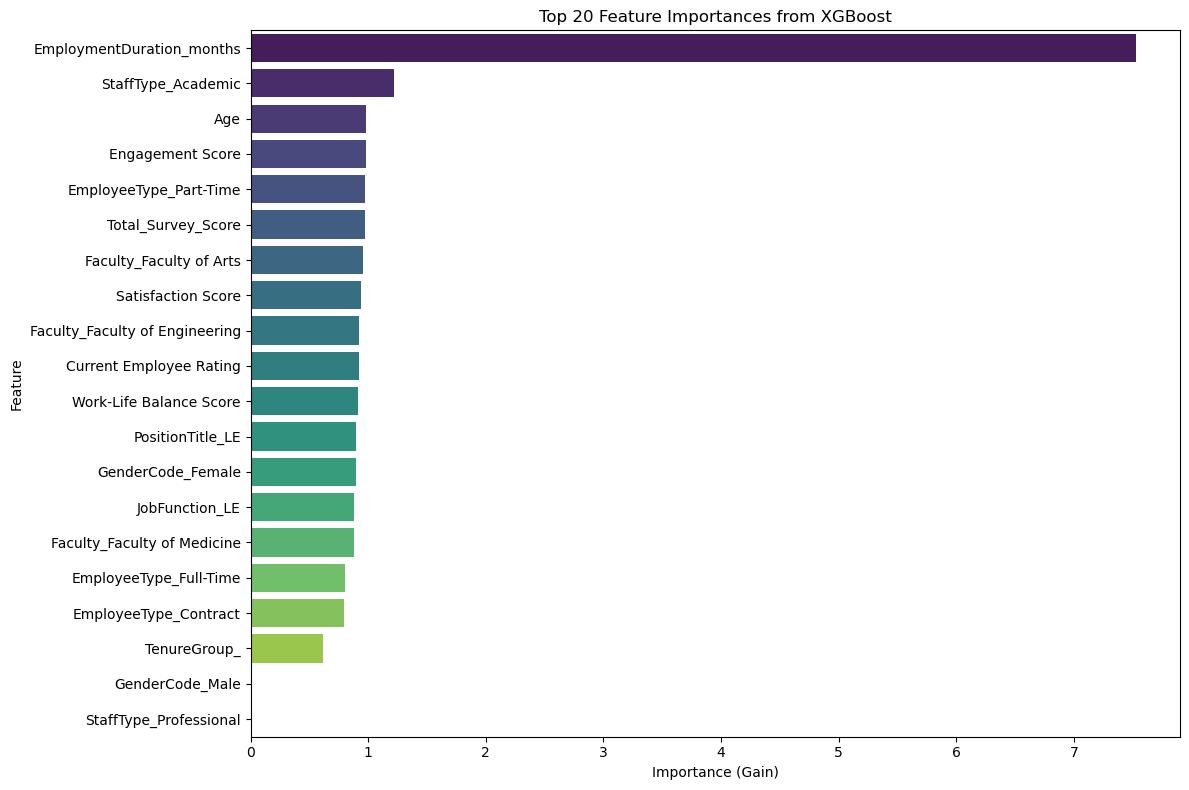

In [421]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming importance_df is created as before
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances from XGBoost')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
